# Clustering (15 points):
Each item is worth 3 points.

For each question that asks to implement a function, implement it in the top cell where it is defined and then execute the function in the code cell provided below the question. <br>
You should base your answers on the output.<br>
You are allowed to implement and use additional functions. These would be defined and implemented in the
cell directly below the questions they were implemented for.

All the textual answers should be based on and justified with output from the data in the code cell above.<br>
For example, if the question asks about the correlation value, the code calculating it should appear above the answer, and the value should be in the output.
The answers should be concise and written in your own words.

### <span style="color:red">Do Not Modify the Structure of this Notebook, don't add/remove/move cells or change their type (Code/Markdown) </span>

1. [Read the feather files 'TrainQuestionsDF.feather.zstd' and 'TestQuestionsDF.feather.zstd' into pandas dataframes named train_df and test_df respectively. <br>Then convert the 'Title' column of each of them into a tf-idf vector, make sure to create the vocabulary only with the train_df, then use the same fitted TfidfVectorizer object to transform the Title column in test_df.](#q1)
<br><br>
2. [Implement the functions `kmeans_clustering(X, **kmean_kwargs)` and `dbscan_clustering(train_tfidf_vec, **dbscan_kwargs)`. <br>Each function should return the clustering model (object) and the clustering labels. Make sure to use the ***RANDOM_SEED*** for the KMeans model instantiation. <br>Then use the train and test tf-idf vectors to cluster the data using the default values for each clustering model.](#q2)
<br><br>
3. [Use the function `plot_k_distance_graph(X, k)` with the test tf-idf vectors and set k=20. <br>Answer the following questions based on the plot with regard to the DBSCAN algorithm.](#q3)
<br><br>
4. [Implement the function `plot_wcss_graph(dataset, k_range, **kmean_kwargs)` and call it with the train data title features and `k_range=range(3, 15)`.](#q4)
<br><br>
5. [Implement the function `plot_v_measure_graph(dataset, k_range, y_true, **kmean_kwargs)` and call it with the train data title features and `k_range=range(3, 15)`.](#q5)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.neighbors import NearestNeighbors

In [2]:
# TODO: Any additional (if needed) import statements should be in this cell
from sklearn import preprocessing
import seaborn as sns

In [3]:
# TODO: Set the random seed as your student id (only numbers)
RANDOM_SEED = 3891013
np.random.seed(RANDOM_SEED)

In [4]:
# This cell is for functions given to you to use

plt.style.use('ggplot')


def read_feather_to_df(feather_file_name):
    """
    The function expects to receive a path to feather file,
    it will read the file from the disk into a pandas dataframe
    """
#     feather.read_feather(feather_file_name)
    return pd.read_feather(feather_file_name)


def plot_k_distance_graph(X, k):
    """
    The function receives a dataset expressed as numerical features and plots the k-distance graph for DBSCAN
    :param X: ndarray, pd.DataFrame or a sparse matrix; data features
    :param k: int; will plot the distances to the k'th nearest neighbor of each sample
    :return: None
    """
    # create a new instance of NearestNeighbors and assign to the variable nbrs
    nbrs = NearestNeighbors(n_neighbors=k + 20)
    # Fit the nearest neighbors estimator on the data
    nbrs.fit(X)
    # Find the "n_neighbors" nearest neighbors for every point, returns indices of and distances to the neighbors of each point in sorted order.
    distances, indices = nbrs.kneighbors(X)
    # remember that the index of the n-th element is n-1
    k_distance = distances[:, k - 1]  # array with the distance of every n-th neighbour
    k_distance = np.sort(k_distance)  # sort in ascending order

    plt.figure(figsize=(15, 10))  # create and define the figure
    plt.plot(k_distance)
    plt.title(f"{k}-distance graph for DBSCAN")
    plt.ylabel("$\epsilon$ distance")
    plt.xlabel("number of core points")
    plt.gca().invert_xaxis()  # gca used to get current axes, then invert_xaxis() will invert the x axis
    plt.grid(True)  # add grid to the plot
    plt.grid(which="major",alpha=0.6)
    plt.grid(which="minor",alpha=0.3)
    plt.show()

In [5]:
# This cell is for all the functions you are expected to implement.
# You should implement them here and only call them below when they are mentioned in a question.

def select_numeric_non_id_columns(df):
    """
    Return a subset of a DataFrame’s columns based on the column dtypes,
    including only numerical columns and excluding columns with the string id (case-insensitive) in their name
    """
    # TODO: write your code here
    numerical_df = pd.DataFrame()
    for x in df:
        c = df[x].dtypes
        if c == "Int64":
            if x != "Id" and x != "PostTypeId" and x != "AcceptedAnswerId" and x != "OwnerUserId" and x != "LastEditorUserId" and x != "ParentId":
               numerical_df[x] = df[x]   
    return numerical_df


def series_to_tfidf(sr, **kwargs):
    """
    The function receives an array or a pandas Series that contains text strings (a.k.a documents).
    It then converts the documents into a matrix of TF-IDF features
    The function should return two objects:
    TfidfVectorizer object after it learned (fitted) the vocabulary and idf from the training set,
    and a document-term matrix (the original documents array transformed into a TF-IDF features matrix).
    """
    # TODO: write your code here
    vectorizer = TfidfVectorizer()
    TfidfVectorizer_object = vectorizer.fit(sr)
    sparse_matrix = vectorizer.fit_transform(sr)
    return TfidfVectorizer_object, sparse_matrix


def kmeans_clustering(X, **kmean_kwargs):
    """
    The function receives a dataset expressed as numerical features, clusters the data and returns the
    fitted clustering model and the cluster labels for the data.
    First test if the number of samples in the dataset is larger or equal to 10,000,
    if it is: use the class MiniBatchKMeans(random_state=RANDOM_SEED, batch_size=2048, **kmean_kwargs)
    it the number of samples is less than 10K, use the class KMeans(random_state=RANDOM_SEED, **kmean_kwargs)
    Add a print call that will indicate which model was used.
    :param X: ndarray, pd.DataFrame or a sparse matrix; data features
    :param kmean_kwargs: key-word arguments that will be passed to kmeans clustering class
    :return: two objects, the fitted clustering object and the cluster labels for the data
    """
    # TODO: write your code here
    if X.shape[0] >= 10000:
        kmeans  = MiniBatchKMeans(random_state=RANDOM_SEED, batch_size=2048, **kmean_kwargs)
        _fit = kmeans.fit(X)
        print("MiniBatchKMeans was used")
    else:
       kmeans = KMeans(random_state=RANDOM_SEED, **kmean_kwargs)
       _fit = kmeans.fit(X)
       print("KMeans was used")
    return _fit, _fit.predict(X)
    


def dbscan_clustering(X, **dbscan_kwargs):
    """
    The function receives a dataset expressed as numerical features, clusters the data and returns the
    fitted clustering model and the cluster labels for the data.
    :param X: ndarray, pd.DataFrame or a sparse matrix; data features
    :param dbscan_kwargs: key-word arguments that will be passed to dbscan clustering class
    :return: two objects, the fitted clustering object and the cluster labels for the data
    """
    # TODO: write your code here
    db = DBSCAN()
    _fit = db.fit(X)
#     labels = db.fit_predict(X)
    return _fit, db.labels_


def plot_wcss_graph(dataset, k_range=range(3, 15), **kmean_kwargs):
    """
    The function receives a dataset expressed as numerical features and plots the WCSS (a.k.a inertia) graph
    using K-Means clustering over a range of K values.
    The y-axis of the graph represents WCSS (inertia) and x-axis the number of clusters.
    The plot should be readable and have proper title and labels.
    You should use the function `kmeans_clustering`.
    :param dataset: ndarray, pd.DataFrame or a sparse matrix; data features
    :param k_range: an iterable object, e.g. list, tuple, range, etc.
    :param kmean_kwargs: key-word arguments that will be passed to kmeans clustering class
    """
    # TODO: write your code here
    sse = []
    for k in k_range:
        kmeans = kmeans_clustering(dataset, n_clusters=k)
        kmeans[0]
        sse.append(kmeans[0].inertia_)
    
    plt.style.use("fivethirtyeight")
    plt.plot(k_range, sse)
    plt.xticks(k_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()


def plot_v_measure_graph(dataset, y_true, k_range=range(3, 15), **kmean_kwargs):
    """
    The function receives a dataset expressed as numerical features and plots the V-measure graph
    using K-Means clustering over a range of K values.
    The y-axis of the graph represents V-measure and x-axis the number of clusters.
    The plot should be readable and have proper title and labels.
    You should use the function `kmeans_clustering` and sklearn's v_measure_score() to calculate the V-measure values.
    :param dataset: ndarray, pd.DataFrame or a sparse matrix; data features
    :param k_range: an iterable object, e.g. list, tuple, range, etc.
    :param y_true: array-like; ground truth class labels
    :param kmean_kwargs: key-word arguments that will be passed to kmeans clustering class
    """
    # TODO: write your code here
    vms = []
    for k in k_range:
        kmeans = kmeans_clustering(dataset, n_clusters=k)
        kmeans[0]
        score = v_measure_score(y_true, kmeans[1])
        vms.append(score)
    
    plt.style.use("fivethirtyeight")
    plt.plot(k_range, vms)
    plt.xticks(k_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("V Measure")
    plt.show()


def plot_silhouette_coefficient_graph(dataset, k_range=range(3, 15), **kmean_kwargs):
    """
    The function receives a dataset expressed as numerical features and plots the silhouette coefficient graph
    using K-Means clustering over a range of K values.
    The y-axis of the graph represents silhouette coefficient and x-axis the number of clusters.
    The plot should be readable and have proper title and labels.
    You should use the function `kmeans_clustering`.
    :param dataset: ndarray, pd.DataFrame or a sparse matrix; data features
    :param k_range: an iterable object, e.g. list, tuple, range, etc.
    :param kmean_kwargs: key-word arguments that will be passed to kmeans clustering class
    """
    # TODO: write your code here
    silhouette_coefficients = []
    for k in k_range:
        kmeans = kmeans_clustering(dataset, n_clusters=k)
        kmeans[0]
        score = silhouette_score(dataset, kmeans[1])
        silhouette_coefficients.append(score)
    
    plt.style.use("fivethirtyeight")
    plt.plot(k_range, silhouette_coefficients)
    plt.xticks(k_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("V Measure")
    plt.show()


### <a name="q1"></a> 1. Read the feather files 'TrainQuestionsDF.feather.zstd' and 'TestQuestionsDF.feather.zstd' into pandas dataframes named train_df and test_df respectively. <br>Then convert the 'Title' column of each of them into a tf-idf vector, make sure to create the vocabulary only with the train_df, then use the same fitted TfidfVectorizer object to transform the Title column in test_df.<br>Answer the following questions below: <br>1.1 What is the shape of the generated tf-idf objects? <br>1.2 What is the size of the generated vocabulary?

In [6]:
# TODO: write your function calls and code here
train_df = read_feather_to_df('TrainQuestionsDF.feather.zstd')
test_df = read_feather_to_df('TestQuestionsDF.feather.zstd')
train_vector = series_to_tfidf(train_df['Title'])[1]
test_vector = series_to_tfidf(train_df['Title'])[0].transform(test_df['Title'])
len(series_to_tfidf(train_df['Title'])[0].vocabulary_)
# train_vector.shape # (21011, 8482)
# test_vector.shape # (5253, 8482)

(5253, 8482)

*Write your answers to 1 here (1-2 sentences per item):* 

1.1) the shape of training set is (21011, 8482) i.e., 21011 samples and 8482 columns<br>
     the shape of test set is (5253, 8482) i.e., 5253 samples and 8482 columns<br><br>
1.2) Length of the vocabulary is 8482

## Intrinsic clustering evaluation
### <a name="q2"></a> 2. Implement the functions `kmeans_clustering(X, **kmean_kwargs)` and `dbscan_clustering(X, **dbscan_kwargs)`. <br>Each function should return the clustering model (object) and the clustering labels. Make sure to use the RANDOM_SEED for the KMeans model instantiation. <br>Then use the train and test tf-idf vectors to cluster the data using the default values for each clustering model. <br>Answer the following questions: <br>2.1 How many clusters were formed for the train data using each clustering method? <br>2.2 Which method achieved a result closer to the actual number of labels? justify you answer with the data <br>2.3 Propose a short possible explanation to the observed outcome in 2.2

In [7]:
# TODO: write your function calls and code here
labels_kmeans_train = kmeans_clustering(train_vector)[1]
labels_kmeans_test = kmeans_clustering(test_vector)[1]
labels_dbscan_train = dbscan_clustering(train_vector)[1]
labels_dbscan_test = dbscan_clustering(test_vector)[1]
print(np.unique(labels_kmeans_train))
print(np.unique(labels_dbscan_train))

MiniBatchKMeans was used
KMeans was used
[0 1 2 3 4 5 6 7]
[-1  0]


*Write your answers to 2 here (1-2 sentences per item):*<br>
2.1) For the training set, in the case of K means clustering, there were 8 labels formed whereas in the case of DBSCAN, only 2 labels were formed and -1 in it indicates noisy samples clustered in one of the labels. <br><br>
2.2) k means clustering achieved a result closer to actual numbers of labels that is 7 and k means returning 8 labels. We know that there are 7 labels when we did data exploration. Besides that, if we look at intetia, V Measure and silhouette coefficient(Implemented and graph can be seen by uncommenting the last cell of the notebook in which the function has been called) graphs, it somehow depicts that there are 12 labels which are still close to 8 which is output for number of labels in k means clustering. Unlike DBSCAN, which is returning only 2 labels, the actual figure is far away and the figures shown by graphs are no way close. So, in conclusion, k means did a much better job. <br><br>
2.3) k means generally clusters all the objects unlike DBSCAN which discards all the objects it defines as a noise. In addition to that, DBSCAN is not that efficient in handling high dimensional dataset and in our case, data has a huge number of features. Thus, k means being efficient in handling high dimensional dataset outperforms DBSCAN. Besides that, DBSCAN needs parameters like minimum points and radius to perform well and it might also be reason for DBSCAN to classify most points as outliers because we didn't pass any parameters. Also, it is a fact that DBSCAN does not work very well with sparse data which is a case over here because we are using text-besed(tf-idf) which generates a sparse matrix. 

### <a name="q3"></a> 3. Use the function `plot_k_distance_graph(X, k)` with the test tf-idf vectors and set k=20. <br>Answer the following questions based on the plot with regard to the DBSCAN algorithm: <br> 3.1 What should be a good epsilon value for this data? <br>3.2 From which epsilon values would DBSCAN likely result with all the samples in the same cluster? <br>3.3 From which epsilon values would DBSCAN likely result with most of the samples as outliers?

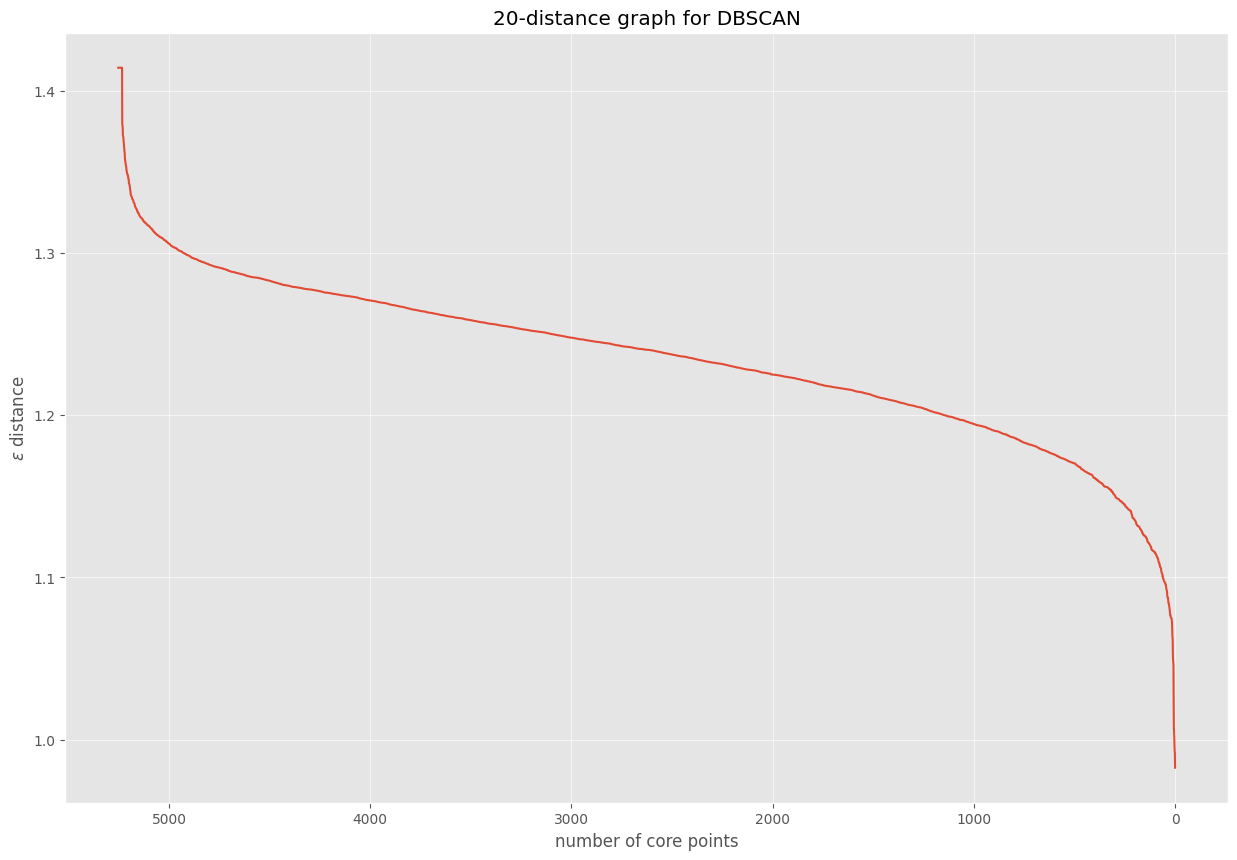

In [8]:
# TODO: write your function calls and code here
plot_k_distance_graph(test_vector, 20)

*Write your answers to 3 here (1-2 sentences per item):*<br>
    3.1) The good epsilon value should around 1.32 <br>
    3.2) From the epsilon value around 1.3 and above, it is most likely that all the samples would lie in the same cluster. 
    <br>
    3.3) From the epsilon value around 1.3 and below will produce most number of outliers as graph is falling significantly(especially at epsilon value = 1.2) so at that point which will only cluster small part of data set and the rest will be treated as outliers. 

### <a name="q4"></a> 4. Implement the function `plot_wcss_graph(dataset, k_range, **kwargs)` and call it with the train data title features and `k_range=range(3, 15)` then answer the following questions:<br> 4.1 Based on the plot, using the "elbow method" which numbers are suitable candidates as a good number of clusters? <br>4.2 Which number of clusters will minimize the WCSS? <br>4.3 What is the rational of the elbow method? Which number of clusters will minimize the WCSS?

MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used


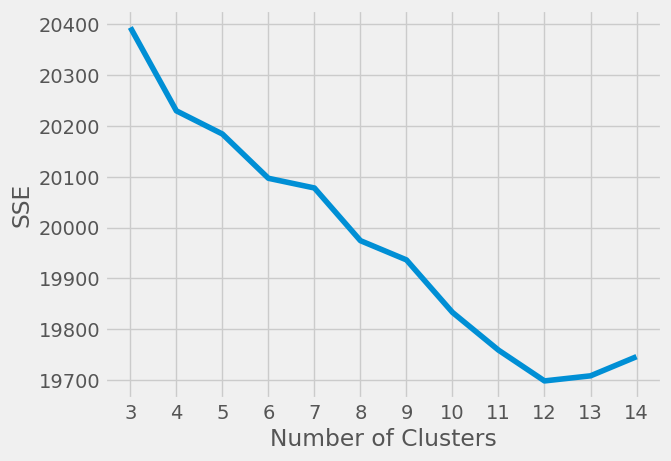

In [9]:
# TODO: write your function calls and code here
k_range=range(3, 15)
plot_wcss_graph(train_vector, k_range)

*Write your answers to 4 here (1-2 sentences per first two items, up to 4 senteces for the third):*<br>
4.1) Based on the plot, 4, 6, 8 and 12(most significant elbow) are suitable candidates as most candidates for good number of clusters.<br>
4.2) number of cluster value = 12 will minimise the WCSS. <br>
4.3) WCSS is the sum of squared distance between each point and the centroid in a cluster. Thus, when the number of clusters increase, WCSS value starts falling, so a lower WCSS value means points in a particular cluster are close to centroid and forms a tight cluster. So we can see in the graph, number of clusters = 12 will result in lowest k value. 

## Extrinsic clustering evaluation
### <a name="q5"></a> 5. Implement the function `plot_v_measure_graph(dataset, k_range, y_true)` and call it with the train data title features and `k_range=range(3, 15)` then answer the following questions:<br> 5.1 Based on the plot, which number of clusters yields the best result? <br>5.2 Compare the result of this extrinsic evaluation measure with the previous intrinsic evaluation results. What are the reasons choose one over the other?

MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used
MiniBatchKMeans was used


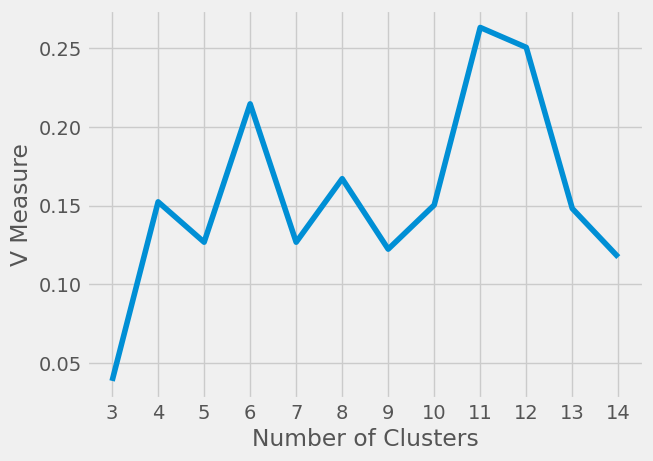

In [10]:
# TODO: write your function calls and code here
k_range=range(3, 15)
label_encoder = preprocessing.LabelEncoder()
y_true = label_encoder.fit_transform(train_df['Label'])
plot_v_measure_graph(train_vector, y_true, k_range)
# np.unique(train_df['Label'])

*Write your answers to 5 here (1-2 sentences for the first item, up to 4 senteces for the second):*<br>
5.1) According to the plot, the best number of cluster which yields the best result is 12 as higher V measure values shows that model produces overall homogenous and complete clusters. 
<br>
5.2) WCSS graph says that most suitable value for number of clusters is 11 whereas V Measure says that most suitable value for number of clusters is 12. Overall, I would like to go with V Measure as it gives mean between homogeneity and completeness and both of them are desirable so higher v Measure value suggests clusters are homogenous and complete overall. 

In [1]:
# k_range=range(3, 15)
# plot_silhouette_coefficient_graph(train_vector,k_range)